# Narrative

In this project I will be using Modified Node Analysis to find the currents at a set of n nodes in a passive circuit. Modified Node Analysis allows uses the processing power of a computer to solve algorithms that find the current through each node and voltage source. Note that for this project I will be only using regular voltage sources and not independent voltage sources. To find the currents through each node using MNA I have to use the equation A * x = z. A is a matrix with dimension m+n, m+n(m being the number of voltage sources and n being the numbe of nodes). X is a matrix(m+n,1) that holds the unknown values of each current through the nodes and voltages in the circuit. Z is also a matrix(m+n,1) that holds the independent voltagtes and current sources. The results that I am looking for in the project will be stored in the x matrix. So in this case the equation that I am going to use is $ A^{-1} * z = x$. 

## Creating the circuit

Before finding out the currents through the nodes and voltage sources I first need to define my system(the circuit that will be used). The way that was the easiest to get the information of the circuit is to create a string that contains the information of all passive components(Resistors) and all voltage sources(batteries). Each line in the string will have either resistor or voltage source, followed by the node connected to the positive side, a node connected to the negative side, and its values. The values will have different descriptors so Resistors will have a value in ohms and voltage sources will have volts. From there the string is split by the end of each line so that information betweem resistors and voltage sources wont intersect. Then I stored all of the data into dictionaries. the reason why dictionaries are being used is so that I can store multiple sets of information for a given node, resitor, and voltage source per index. The main reason as to why the string did not have a section for nodes was because all the nodes in the circuit have to be connected to either a passive element or a voltage source. Thus by getting the positive and negative nodes from each resistor and voltage source, I can the categorize the nodes to a dictionary containing lists of the positve and negative nodes. There also is a zero node in the circuit. That node will always be ground since a circuit needs to be grounded in order to work. the circuit that I will be working on for this project is: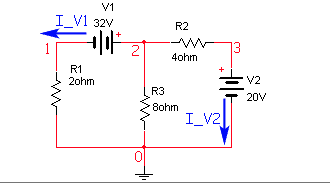



In [1]:
import numpy as np
import numpy.linalg as la #used for linear algebra

In [2]:
# specify the circuit using the same format as a SPICE file

# spice = """Vs1 0 1 32
# R1 1 2 2
# R2 2 3 4
# R3 0 2 8
# Vs2 0 3 20"""


# Voltage Divider # name negnode posnode value
# spice = """Vs1 0 1 10
# R1 1 2 2
# R2 2 0 3"""

# Current Divider
# spice = """Is1 0 1 3
# R1 0 1 50
# R2 0 1 100"""

# Example 2
# spice = """Vs1 1 2 32
# Vs2 0 3 20
# R1 0 1 2
# R2 0 2 8
# R3 2 3 4"""

# Example 3
# spice = """Is1 0 1 0.01
# R1 0 1 50
# R2 1 2 100
# R3 0 2 200
# Vs1 2 1 5"""

# case 1
spice = """Vs1 1 2 32
Vs2 0 3 20
R1 0 1 2
R2 2 3 4
R3 0 2 8""" 

# case 2

# circuit is a list with each item being a line in the spice string
circuit = spice.split('\n')
print("circuit: ", circuit)

# dictionary of nodes
nodes = {
    "neg": [],
    "pos": []
}

# lists of circuit elements
Vsources = []
Rs = []
Isources = []

# read each line in the circuit and populate the nodes dictionary and lists of circuit elements
for line in circuit:
    element, neg, pos, val = line.split(' ')
    neg = int(neg)
    pos = int(pos)
    val = float(val)
    name = element[1:]
    if neg not in nodes['neg']:
        nodes['neg'].append(neg)
    if pos not in nodes['pos']:
        nodes['pos'].append(pos)
        
    elementDict = {
        "name": name,
        "neg": neg,
        "pos": pos,
        "val": val
    }
    
    if element[0] == 'V':
        Vsources.append(elementDict)
    elif element[0] == "I":
        Isources.append(elementDict)
    elif element[0] == "R":
        Rs.append(elementDict)

# number of nodes
n = np.max(nodes['pos'])

# number of voltage sources
m = len(Vsources)

print("Number of nodes, n = ", n)
print("Number of V sources, m = ", m)
print("V sources: ",Vsources)
print("I sources: ",Isources)
print("Resistors: ",Rs)
print("Neg nodes:", nodes['neg'])
print("Pos nodes:", nodes['pos'])

circuit:  ['Vs1 1 2 32', 'Vs2 0 3 20', 'R1 0 1 2', 'R2 2 3 4', 'R3 0 2 8']
Number of nodes, n =  3
Number of V sources, m =  2
V sources:  [{'name': 's1', 'neg': 1, 'pos': 2, 'val': 32.0}, {'name': 's2', 'neg': 0, 'pos': 3, 'val': 20.0}]
I sources:  []
Resistors:  [{'name': '1', 'neg': 0, 'pos': 1, 'val': 2.0}, {'name': '2', 'neg': 2, 'pos': 3, 'val': 4.0}, {'name': '3', 'neg': 0, 'pos': 2, 'val': 8.0}]
Neg nodes: [1, 0, 2]
Pos nodes: [2, 3, 1]


# Implementing the algorithms

To be able to find the currents through each node and VS(voltage source) I first needed to calculate the contents of both the A matrix and the Z matrix. The A matrix consists of multiple different matrices that each have a specific purpose to find what I am looking for. The matrices stored in A are: G ,B, C, amd D. These matrices each have values that tell the full story as to how to find the currents. All matrices will be made into functions except for the C. 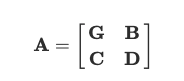


## The G matrix

The G matrix is a nxn dimensional matrix and is determined by the interconnects between nodes and passive elements. The values of the G matrix will be either 0 or a combonation of conductances for each node. The conductance of a node is $\frac{1}{R_n}$. Depending on the placement of the node there is the possibility that a node is connected to more than one passive elements. In that case all you would have to do is add the values of the resistors together to find the conductance for a node connecting to multiple passive elements. G is seperated into two algorithms to solve: The diagnal and everything else. The diagnal in the matrix represents the sum of conducance of a particular node. Since each row in G represents a node; row[0],col[0] would be the sum of conductances of node 1. for the off diagnal elemtns in G they will hold the negative conductance of the node. For the circuit that I am working with G would look like this:


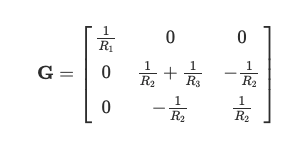

Note that all of the values of G will be in ohms.

### G Results

after implementing the two constraints for the G matrix I found that my values matched what the non numerical resitls were supposed to be. 

In [3]:
# This will make the G matrix.
# G matrix is nxn matrix.
def G(Rlist, nodelist):
    n = len(nodelist['pos']) # list of all positive nodes
    g = np.zeros((n,n)) # place holders for g matrix

    for Grow in range(n):
        for Gcol in range(n):
            if Grow == Gcol: #diagonal
                conductance = 0
                for R in Rs:
                    if R['neg'] == Grow+1:
                        conductance = conductance + 1/R['val']
                    elif R['pos'] == Grow+1:
                        conductance = conductance + 1/R['val']
                g[Grow,Grow] = conductance
                
            else: # if it is not a diagonal
                conductance = 0
                for R in Rs:
                    if R['neg'] == Grow+1 and R['pos'] == Gcol + 1:
                        conductance = conductance + -1/R['val']
                    elif R['pos'] == Grow+1 and R['neg'] == Gcol + 1:
                        conductance = conductance + -1/R['val']                        
                g[Grow,Gcol] = conductance
                
        
    return g

In [5]:
# does a check to see if G matrix holds the correct values
g=G(Rs,nodes)
print(g)

[[ 0.5    0.     0.   ]
 [ 0.     0.375 -0.25 ]
 [ 0.    -0.25   0.25 ]]


## The B matrix

The B matrix is a nxm dimensional matrix(n being the number of nodes and m being the number of VS's). Unlike its predecessor the G matrix, B and all of the other matrices will only hold the values 0,1, or -1. The purpose of the B matrix is to identify what node is connected to the positive or negative side of the VS's. The rows in B represent the node while the columns of B represent the voltage source. So row[0] col[0] would be node 1 Voltage Source 1. B is a very simple matrix to solve since its values are determined by what side of the voltage source is a node connected to. If the node is connected to the positive side of the voltage source then it will be assigned the value 1. If its the negative side then it will be -1. The last possible option is if it a node is not touching a voltage source, then the value will be 0.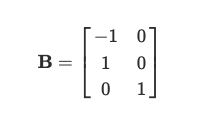

In [4]:
# This will make the B matrix
# B matrix is nxm

def B(Vlist, nodelist):
    n = len(nodelist['pos'])
    m = len(Vlist)
    b = np.zeros((n,m))
    
    for i in range(m): #loop through voltage sources
        for k in range(n): #loop through nodes
            Vs = i + 1
            node = k + 1
            if Vlist[i]['pos']==node:
                b[k,i] = 1
            elif Vlist[i]['neg']==node:
                b[k,i] = -1
    
    return b


In [6]:
b = B(Vsources,nodes)
print(b)

[[-1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


## The C matrix

Just like the B matrix the C matrix will hold the values 1,-1, and 0. This matrix is the transpose of the B matrix so its values will be the same as the B matrix with the only difference being that the dimensions of the matrix will be flipped. 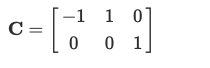

In [7]:
c = np.transpose(b)
print(c)

[[-1.  1.  0.]
 [ 0.  0.  1.]]


## The D matrix 
The purpose of the D matrix is to hold the values of the currents in the system. The dimensions are m,m. where m is the number of voltage sources in the system. Depending on what the circuit has the values of the D matrix will change. If there is only independent sources then the D matrix will hold all 0's for each element in the array. If there are depeendent variable then the answer will be non-zero. In this case since I am only going to be working with independent voltage sources the D matrix will always be 0. 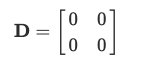

In [8]:
# This will make the D matrix
# d matrix is mxm

def D(vlist):
    m = len(vlist)
    d = np.zeros((m,m))
    
    return(d)
    

In [9]:
d = D(Vsources)
print(d)

[[0. 0.]
 [0. 0.]]


## The Z matrix

The Z matrix is a n+m, 1 dimensional matrix where n is the number of nodes and m is the number of voltage sources. The Z matrix holds all known voltage values for the system. This matrix is broken up into two different matrixces called i and e. I which is a n,1 dimentsinal matrix that holds the sum of the current sources for each node. If there are no current sources connected to the node then the value of the node in i will be 0. E is a m,1 dimensional matrix that holds the values of the independent voltage sources. The structure of the Z matrix starts with i and then with e, which means that the current source values of each node will be at the top of the Z matrix while the independent voltage source values will be stored in the bottom of the Z matrix. 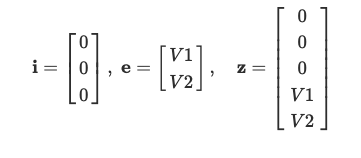

In [10]:
# Creation of e and i matricies

def Z(vlist,nodelist):
    n = len(nodelist['pos'])
    m = len(vlist)
    
    e = np.zeros((m, 1))
    i = np.zeros((n,1))
    z = np.zeros((n+m,1))
    
    for Erow in range(m): # loops through the vsource values
            e[Erow] = Vsources[Erow]['val']
            
    for Zrow in range(m+n):
        if Zrow< n:
            z[Zrow] = i[Zrow] # assigns i values
        elif Zrow >= n: # assigns e values
            z[Zrow] = e[Zrow - n]
            
    return z

In [11]:
z = Z(Vsources,nodes)
print(z)

[[ 0.]
 [ 0.]
 [ 0.]
 [32.]
 [20.]]


## Creation of the A matrix

The A matrix is an n+m, n+m dimensional matrix that holds the 4 matrices G,B,C, and D. A is the place holder that holds all the previous information of the previuos matrices. N represents the number of nodes in the circuit while m represents the number of Voltage sources in the circuit. The output of A should have the results of each matrix above. 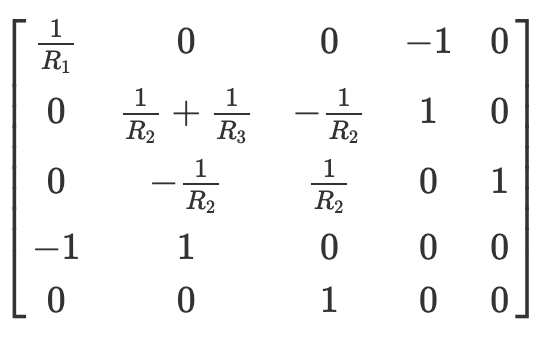

In [12]:
def A(node,Vs):
    n = len(node['pos'])
    m = len(Vs)
    b = B(Vsources,nodes)
    g = G(Rs,nodes)
    c = np.transpose(b)
    d = D(Vsources)
    a = np.zeros((n + m,n + m)) 
    
    a[:n,:n] = g[:,:]
    a[:n,n:] = b[:,:]
    a[n:,:n] = c[:,:]
    a[n:,n:] = d[:,:]
    return a



In [13]:
a = A(nodes,Vsources)
print(a)

[[ 0.5    0.     0.    -1.     0.   ]
 [ 0.     0.375 -0.25   1.     0.   ]
 [ 0.    -0.25   0.25   0.     1.   ]
 [-1.     1.     0.     0.     0.   ]
 [ 0.     0.     1.     0.     0.   ]]


## Solving for X

The way that the source I used to understand MNA used the equation $A *x = z$ Which would look like this: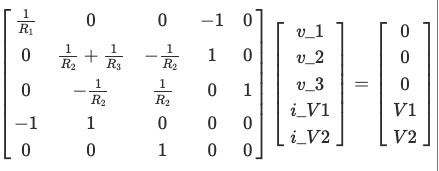


The issue with this equation is that I am looking for the X matrix and the equation is solving for Z. So to find the results for X I would have to do the inverse of A times Z to get the results of my unknown currents X. $ A^{-1} * z = x$ 

Initially when looking at the equation that my source showed me only showed what Z would be and it did not tell me that A had to be the inverse of A to do the equation necessary for finding X. Another issue that arised was finding out if the values I got for X were actually correct.

## Validating My Work

To validate if my code worked I realised that by doing the original equation $A *x = z$ I could compare the results of the equation with the already calculated Z matrix. After compiling my code the results that I got showed that the values of the voltage sources were correct, however the values for the i matrix did not seem to match. The results that my code gave me put the values in exponential notation so after converting them back into regular numerical notation I found that the outlier in my code was so small that it could be assumed that it is 0. Now that my results are validated I am confidenent to say that the code works properly.

In [14]:
a = A(nodes,Vsources)
z = Z(Vsources,nodes)
a_inv = np.linalg.inv(a)

#print(a)
#print(z)
#print(a_tran)
x = np.dot(a_inv,z)
print(x)




[[-8.]
 [24.]
 [20.]
 [-4.]
 [ 1.]]


In [15]:
check = np.dot(a,x)
print(check)

[[-8.8817842e-16]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 3.2000000e+01]
 [ 2.0000000e+01]]


## How to improve this project

Some ways to imporve/investigate this porject is to see what the voltages will be with dependant and current sources. Also another idea to investigate is what the voltages will be once time is involved. 

# Sources

The information used in this project was from both my Professor Dr. Titus and the website: 
[click this link](https://lpsa.swarthmore.edu/Systems/Electrical/mna/MNA3.html#The_A_matrix)